In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

from copy import deepcopy
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib import colors
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy
from sklearn import manifold
from scipy.fftpack import fft, ifft, ifftshift
from scipy.signal import butter, lfilter
from spynal.spikes import density
import sys
import torch
from tqdm.auto import tqdm

plt.style.use('/om2/user/eisenaj/code/ChaoticConsciousness/sci_style.py')

sys.path.append('../..')
from data_utils import get_data_class, load_session_data, load_window_from_chunks

sys.path.append('/om2/user/eisenaj/code/DeLASE')
from delase import *
from dmd import embed_signal_torch
from utils import numpy_torch_conversion

In [3]:
class PCA:
    def __init__(self, n_components=None, use_torch=False, device='cpu', dtype='torch.DoubleTensor'):
        self.n_components = n_components
        self.use_torch = use_torch
        self.device = device
        self.dtype = dtype
        
    def compute_multidim_mean(self, data):
        return data.mean(axis=tuple(np.arange(0, len(data.shape)-1)))
    
    def fit(self, data):
        data = numpy_torch_conversion(data, self.use_torch, self.device, self.dtype)   
        data_centered = data - self.compute_multidim_mean(data)
        if self.use_torch:
            U, S, Vh = torch.linalg.svd(data_centered, full_matrices=False)
            self.U = U
            self.S = S
            self.V = Vh.T

        else:
            U, S, Vh = np.linalg.svd(data_centered, full_matrices=False)
            self.U = U
            self.S = S
            self.V = Vh.T
        
        self.explained_variance_ = ((S**2)/(data.shape[0] - 1))[:self.n_components]
    
    def transform(self, data):
        data = numpy_torch_conversion(data, self.use_torch, self.device, self.dtype)
        data_centered = data - self.compute_multidim_mean(data)
        return ((data_centered) @ self.V[:, :self.n_components]).cpu().numpy()

    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

# Load Data

In [4]:
session = 'MrJones-Anesthesia-20160109-01'
# session = 'Mary-Anesthesia-20160912-02'
results_dir = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/session_results'

In [5]:
all_data_dir = '/scratch2/weka/millerlab/eisenaj/datasets/anesthesia/mat'
data_class = get_data_class(session, all_data_dir)

os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
# variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
# session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
# electrode_info, lfp, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

variables = ['electrodeInfo', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'trialInfo', 'unitInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, lfp_schema, session_info, spike_times, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['spikeTimes'], session_vars['trialInfo'], session_vars['unitInfo']

In [6]:
eyes_open = session_info['eyesOpen'][-1] if isinstance(session_info['eyesOpen'], np.ndarray) else session_info['eyesOpen']
eyes_close = session_info['eyesClose'][-1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']

In [7]:
section_times = dict( 
        wake=(0, session_info['drugStart'][0]),
        induction=(session_info['drugStart'][0], eyes_close),
        anesthesia=(eyes_close, session_info['drugEnd'][1]),
        recovery=(session_info['drugEnd'][1], T*dt)
)
sections = list(section_times.keys())

In [8]:
tone_on = trial_info['cpt_toneOn'][~np.isnan(trial_info['cpt_toneOn'])]
tone_off = trial_info['cpt_toneOff'][~np.isnan(trial_info['cpt_toneOff'])]
puff_on = trial_info['cpt_puffOn'][~np.isnan(trial_info['cpt_puffOn'])]

# Load LFP Directory

In [9]:
dir_ = f"/scratch2/weka/millerlab/eisenaj/datasets/anesthesia/mat/propofolPuffTone/{session}_lfp_chunked_20s"

In [10]:
directory = pd.read_pickle(os.path.join(dir_, "directory"))

# Load Data

In [11]:
# window = 15 # s
window = 30 # s
start_wake = 2500 # s
start_anesthesia = session_info['drugStart'][1] - 500 # s

In [12]:
norm = colors.Normalize(vmin=0, vmax=int(window/dt))
cmap = plt.cm.get_cmap('RdYlBu_r')
color_list = [cmap(norm(i)) for i in range(int(window/dt))]

# Analyze

In [13]:
def smooth_signal(x, gaussian_width=0):
    if gaussian_width > 0:
        x_smoothed = np.zeros(x.shape)
        for i in range(x.shape[1]):
            x_smoothed[:, i] = scipy.ndimage.gaussian_filter1d(x[:, i], gaussian_width)
    else:
        x_smoothed = x.copy()
    
    return x_smoothed

In [14]:
n_components = 3

In [15]:
embedding_funcs = {
    'PCA': lambda kwargs: PCA(**kwargs),
    'Spectral Embedding': lambda kwargs: manifold.SpectralEmbedding(**kwargs),
    'Isomap': lambda kwargs: manifold.Isomap(**kwargs),
    'Locally Linear Embedding': lambda kwargs: manifold.LocallyLinearEmbedding(method="standard", **kwargs),
    'Local Tangent Space Alignment': lambda kwargs: manifold.LocallyLinearEmbedding(method="ltsa", **kwargs),
}



In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

embed_dict = {
#     'PCA': dict(
#         n_components=n_components,
#         use_torch=True,
#         device=device
#     ),
    
#     'Spectral Embedding': dict(
#         n_components=n_components,
# #         n_neighbors=200,
#         n_neighbors=int(window*(1/dt)*(1/15))
#     ),
    
#     'Isomap': dict(
#         n_components=n_components,
#         n_neighbors=200
#     ),
    
#     'Locally Linear Embedding': dict(
#         n_components=n_components,
#         n_neighbors=200,
#     ),
    
    'Local Tangent Space Alignment': dict(
        n_components=n_components,
#         n_neighbors=int(window*(1/dt)*(1/15)),
        n_neighbors=250,
    ),
}

In [17]:
shared_basis = False
standardize = True
# gaussian_width = int(0.01/dt)
gaussian_width = 0
# pca_explained_variance =  0.99
pca_dims = 12
delay_p = 32
delay_tau = 20
# delay_tau = 15
subsample = 3

In [18]:
# EMBED = 'Locally Linear Embedding'
EMBED = 'Local Tangent Space Alignment'
# EMBED = 'Isomap'
# EMBED = 'Spectral Embedding'

In [19]:
areas_to_include = ['vlPFC', 'FEF', '7b', 'CPB']
electrode_indices = np.array([False]*len(electrode_info['area']))
for area in areas_to_include:
    electrode_indices = np.logical_or(electrode_indices, electrode_info['area'] == area)
electrode_indices = np.where(electrode_indices)[0]

In [26]:
trial_info['cpt_refTime']

array([2465.00213333, 2469.38623333, 2475.32966667, ..., 8471.4478    ,
       8477.11303333, 8481.19993333])

In [20]:
session_info['drugStart'][0], session_info['eyesClose'], session_info['drugStart'][1]

(3548.040266666667, 4441.511966666667, 5348.040266666667)

In [27]:
if 'Mary' in session:
    shift_w = (548.37086667 - 1.37) - start_wake
else:
    # shift_w = (2672.6031 - 1.37) - start_wake
    # shift_w = (3000 - 1.37) - start_wake
    shift_w = 2700 - start_wake
    
#     shift_w = (559.23773333 - 1.37) - start_wake
# shift_w = (tone_on[60] - 1.37) - start_wake
print(f"start_wake = {start_wake + shift_w}")
print(f"tone times = {tone_on[(tone_on >= start_wake + shift_w) & (tone_on <= start_wake + shift_w + window)]}")
print(f"puff times = {puff_on[(puff_on >= start_wake+shift_w) & (puff_on <= start_wake+shift_w + window)]}")

start_wake = 2700
tone times = [2703.99503333 2710.40496667 2724.24373333 2729.63063333]
puff times = [2704.99343333 2711.40203333 2716.6961     2720.9683     2725.2406    ]


In [28]:
if 'Mary' in session:
    shift_a = (1969.6065 - 1.37) - start_anesthesia
else:
    # shift_a = (5022.42016667 - 1.37) - start_anesthesia
    shift_a = (6000 - 1.37) - start_anesthesia

# shift_a = (tone_on[373] - 1.37) - start_anesthesia
print(f"start_anesthesia = {start_anesthesia + shift_a}")
print(f"tone times = {tone_on[(tone_on >= start_anesthesia + shift_a) & (tone_on <= start_anesthesia + shift_a + window)]}")
print(f"puff times = {puff_on[(puff_on >= start_anesthesia+shift_a) & (puff_on <= start_anesthesia+shift_a + window)]}")

start_anesthesia = 5998.63
tone times = [6003.7689     6008.6908     6014.72866667]
puff times = [6004.76743333 6009.69003333 6015.72696667 6020.83523333 6027.2441    ]


In [29]:
if not shared_basis:
    all_embedded_signals = {}
    for t in tqdm([start_wake + shift_w, start_anesthesia + shift_a]):
#     for t in tqdm([start_anesthesia + shift_a]):
        signal = load_window_from_chunks(t, t + window, directory, electrode_indices)
        # PCA
        if pca_dims >= 0:
            pca = PCA(n_components=2, use_torch=True, device=device)
            pca.fit(signal)
#             pca_evr = np.cumsum(((pca.S**2)/(pca.S**2).sum()).cpu().numpy())
#             ind = np.argmax(pca_evr >= pca_explained_variance)
#             pca.n_components = ind - 1
            pca.n_components = pca_dims
            signal = pca.transform(signal)
        # gaussian blur
        signal = smooth_signal(signal, gaussian_width)
        
        # delay
        signal = embed_signal_torch(signal, delay_p, delay_tau)
        
        if standardize:
            signal = (signal - signal.mean())/signal.std()
        
        signal = signal[np.arange(0, signal.shape[0], subsample)]
        
        embedded_signals = {}
        for embed_func, embed_kwargs in embed_dict.items():
            embed = embedding_funcs[embed_func](embed_kwargs)
            if embed_func == EMBED:
#                 raise ValueError
                embedded_signals[embed_func] = embed.fit_transform(signal)
        
        all_embedded_signals[t] = embedded_signals
else:
    all_embedded_signals = {}
    for t_wake, t_anesthesia in tqdm([(start_wake + shift_w, start_anesthesia + shift_a)]):
        signals = []
        for t in [t_wake, t_anesthesia]:
            signal = load_window_from_chunks(t, t + window, directory, electrode_indices)

            
            # PCA
            if pca_dims >= 0:
                pca = PCA(n_components=2, use_torch=True, device=device)
                pca.fit(signal)
    #             pca_evr = np.cumsum(((pca.S**2)/(pca.S**2).sum()).cpu().numpy())
    #             ind = np.argmax(pca_evr >= pca_explained_variance)
    #             pca.n_components = ind - 1
                pca.n_components = pca_dims
                signal = pca.transform(signal)
            # gaussian blur
            signal = smooth_signal(signal, gaussian_width)

            # delay
            signal = embed_signal_torch(signal, delay_p, delay_tau)
            
            if standardize:
                signal = (signal - signal.mean())/signal.std()
                
            signal = signal[np.arange(0, signal.shape[0], subsample)]
            
            signals.append(signal)
        
        all_embedded_signals[t_wake] = {}
        all_embedded_signals[t_anesthesia] = {}
        for embed_func, embed_kwargs in embed_dict.items():
            embed = embedding_funcs[embed_func](embed_kwargs)
            if embed_func == EMBED:
                embedded_shared = embed.fit_transform(np.vstack(signals))
                all_embedded_signals[t_wake][embed_func] = embedded_shared[:signals[0].shape[0]]
                all_embedded_signals[t_anesthesia][embed_func] = embedded_shared[signals[0].shape[0]:]
            

  0%|          | 0/2 [00:00<?, ?it/s]

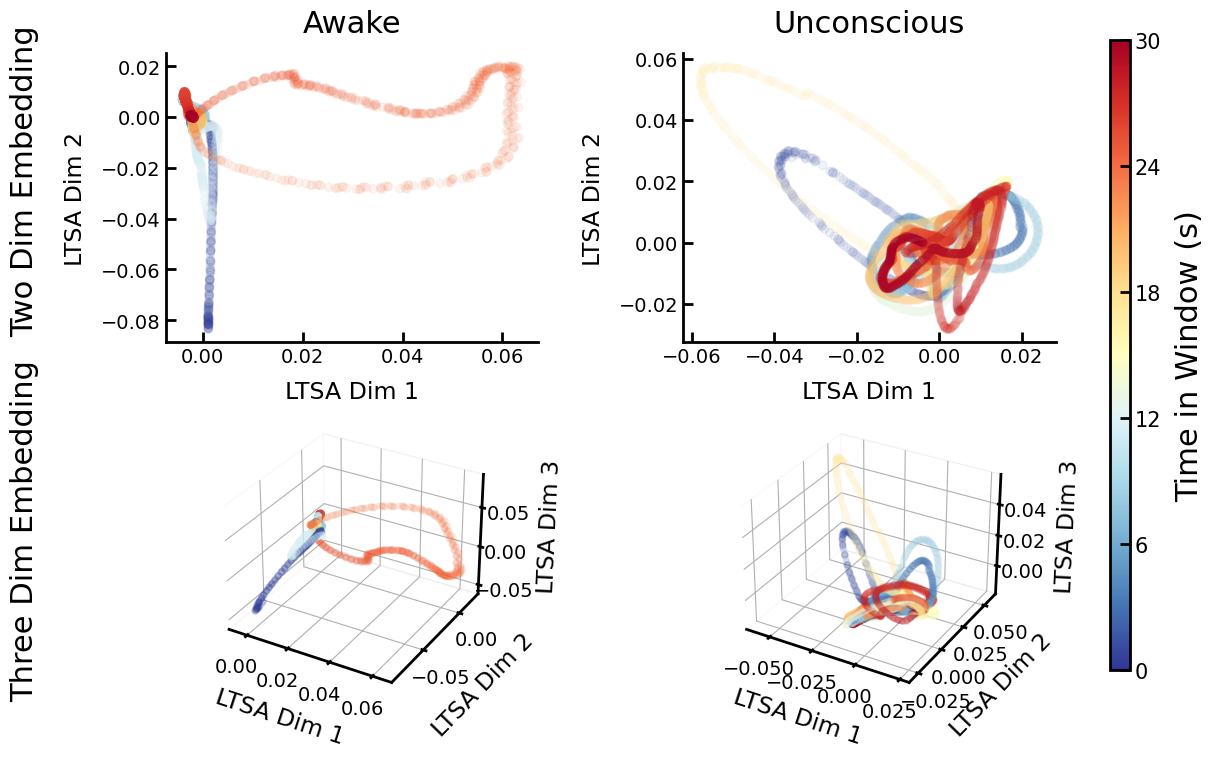

In [30]:
# Combo Plot

ysuplabel_fontsize = 22
xlabel_fontsize = 17
ylabel_fontsize = 17
zlabel_fontsize = 17
title_fontsize = 22
tick_fontsize = 14
clabel_fontsize = 22

alpha = 0.075

fig = plt.figure(layout='constrained', figsize=(10, 7))
subfigs = fig.subfigures(1, 2, wspace=0.07, hspace=0.07)

for plot_ind, t in enumerate(all_embedded_signals.keys()):

    
    embedded_signals = {}
    embedded_signals[embed_func] = all_embedded_signals[t][embed_func]
    
#     color_list4 = np.array([(1/256, 1/256, 1/256, 1.0)]*len(color_list))

#     for t_tone in tone_on[np.logical_and(tone_on >= t, tone_on <= t + window)]:
#         start = int((t_tone - t)/dt)
#         end = np.min([int((t_tone - t)/dt) + 1000, len(color_list)])
#         color_list4[start:end] = plt.cm.get_cmap('BuGn')(np.linspace(0, 1, end-start))
# #         subsampled_inds = np.arange(int(window/dt))[np.arange(0, int(window/dt), subsample)]
# #         plot_inds = np.where(np.logical_and(subsampled_inds >= start, subsampled_inds < end))[0]
# #         plot_inds -= int((delay_p - 1)*delay_tau/subsample)

#     for t_puff in puff_on[np.logical_and(puff_on >= t, puff_on <= t + window)]:
#         start = int((t_puff - t)/dt)
#         end = np.min([int((t_puff - t)/dt) + 1000, len(color_list)])
#         color_list4[start:end] = plt.cm.get_cmap('YlOrRd')(np.linspace(0, 1, end-start))

    cmap = plt.cm.get_cmap('RdYlBu_r')
    color_list4 = cmap(np.linspace(0, 1, int(window/dt)))

    #     alpha[input_vec > 0] = 1
    #     alpha = alpha[np.arange(0, len(color_list), subsample)][-embedded_signals[embed_func].shape[0]:]

    
#     prev_val = None
#     power = 0
#     for i, input_val in enumerate(input_vec):

#         if prev_val == input_val:
#             power += 1
#         else:
#             power = 0
#         if input_val == 1:
#             B = np.linspace(0.5717531718569781, 1, 1000)
#             color_list4[i] = (0.5056516724336794, 0.7190311418685121, B[power], 1.0)
#         elif input_val == 3:
#             G = np.linspace(0.6173779315647828, 1, 1000)
#             color_list4[i] = (0.9831603229527105, G[power], 0.35040369088811996, 1.0)
#         elif input_val == 4:
#             R = np.linspace(0.8417531718569781, 1, 1000)
#             color_list4[i] = (R[power], 0.9690119184928874, 0.7020376778162245, 1.0)
#         if i > 0:
#             prev_val = input_vec[i - 1]

    # plt.figure(figsize=(8, 5))
    axs = subfigs[plot_ind].subplots(2, 1)
    axs[0].scatter(embedded_signals[embed_func][:, 0], embedded_signals[embed_func][:, 1], color=np.array(color_list4)[np.arange(0, int(window/dt), subsample)][-embedded_signals[embed_func].shape[0]:], alpha=alpha)
    axs[1].remove()
    axs[1]=subfigs[plot_ind].add_subplot(2, 1, 2, projection='3d')
    axs[1].scatter(embedded_signals[embed_func][:, 0], embedded_signals[embed_func][:, 1], embedded_signals[embed_func][:, 2], color=np.array(color_list4)[np.arange(0, int(window/dt), subsample)][-embedded_signals[embed_func].shape[0]:], alpha=alpha)
    
    axs[1].w_xaxis.pane.fill = False
    axs[1].w_yaxis.pane.fill = False
    axs[1].w_zaxis.pane.fill = False
    
    axs[0].spines[['right', 'top']].set_visible(False)
    axs[0].xaxis.set_ticks_position('bottom')
    axs[0].tick_params(axis='y', which='both', left=True, right=False)
    for ax in axs:
        ax.set_xlabel('LTSA Dim 1', fontsize=xlabel_fontsize)
        ax.set_ylabel('LTSA Dim 2', fontsize=ylabel_fontsize)
        ax.tick_params(labelsize=tick_fontsize)
    axs[1].set_zlabel('LTSA Dim 3', fontsize=zlabel_fontsize)
    
    axs[0].set_title(['Awake', 'Unconscious'][plot_ind], fontsize=title_fontsize)
    
    if plot_ind == 0:
        fig.text(-0.05, 0.75, 'Two Dim Embedding', va='center', rotation='vertical', fontsize=ysuplabel_fontsize)
        fig.text(-0.05, 0.25, 'Three Dim Embedding', va='center', rotation='vertical', fontsize=ysuplabel_fontsize)


# stack = np.vstack((plt.cm.get_cmap('BuGn')(np.linspace(0, 1, 128)), plt.cm.get_cmap('YlOrRd')(np.linspace(0, 1, 128))))
# mymap = colors.LinearSegmentedColormap.from_list('my_colormap', stack)
# fig.legend(bbox_to_anchor=(0.5, -0.1), loc='center', ncol=5)

sm = plt.cm.ScalarMappable(cmap=cmap)
# fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([1.05, 0.05, 0.02, 0.9])
cbar = fig.colorbar(sm, ticks=[0, 0.2, 0.4, 0.6, 0.8, 1], cax=cbar_ax)
cbar.ax.set_yticklabels([0, 6, 12, 18, 24, 30], fontsize=15)
cbar.set_label('Time in Window (s)', fontsize=clabel_fontsize)

plt.show()

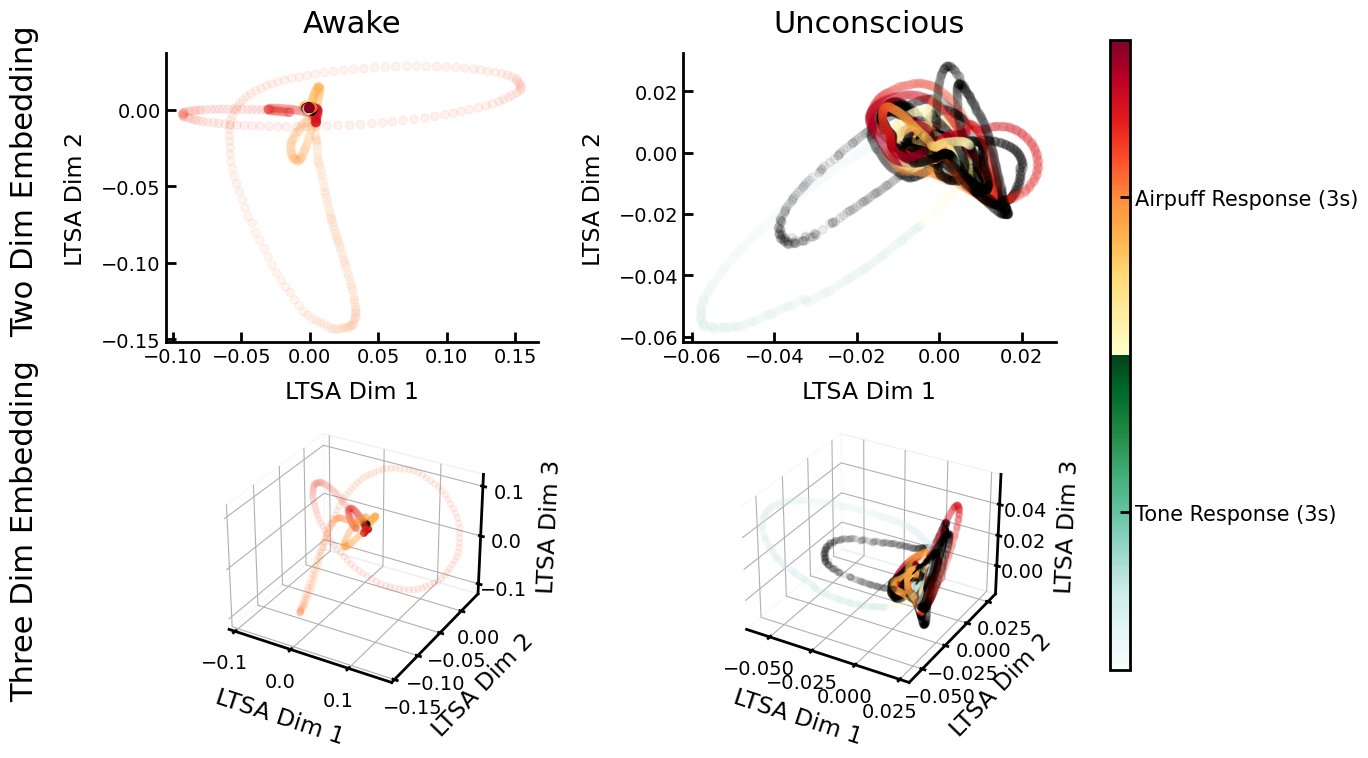

In [27]:
# Combo Plot

# stim_length = 1000
stim_length = 3000

ysuplabel_fontsize = 22
xlabel_fontsize = 17
ylabel_fontsize = 17
zlabel_fontsize = 17
title_fontsize = 22
tick_fontsize = 14

alpha = 0.075

fig = plt.figure(layout='constrained', figsize=(10, 7))
subfigs = fig.subfigures(1, 2, wspace=0.07, hspace=0.07)

for plot_ind, t in enumerate(all_embedded_signals.keys()):

    
    embedded_signals = {}
    embedded_signals[embed_func] = all_embedded_signals[t][embed_func]
    
    color_list4 = np.array([(1/256, 1/256, 1/256, 1.0)]*len(color_list))

    for t_tone in tone_on[np.logical_and(tone_on >= t, tone_on <= t + window)]:
        start = int((t_tone - t)/dt)
        end = np.min([int((t_tone - t)/dt) + stim_length, len(color_list)])
        color_list4[start:end] = plt.cm.get_cmap('BuGn')(np.linspace(0, 1, end-start))
#         subsampled_inds = np.arange(int(window/dt))[np.arange(0, int(window/dt), subsample)]
#         plot_inds = np.where(np.logical_and(subsampled_inds >= start, subsampled_inds < end))[0]
#         plot_inds -= int((delay_p - 1)*delay_tau/subsample)

    for t_puff in puff_on[np.logical_and(puff_on >= t, puff_on <= t + window)]:
        start = int((t_puff - t)/dt)
        end = np.min([int((t_puff - t)/dt) + stim_length, len(color_list)])
        color_list4[start:end] = plt.cm.get_cmap('YlOrRd')(np.linspace(0, 1, end-start))

    #     alpha[input_vec > 0] = 1
    #     alpha = alpha[np.arange(0, len(color_list), subsample)][-embedded_signals[embed_func].shape[0]:]

    
#     prev_val = None
#     power = 0
#     for i, input_val in enumerate(input_vec):

#         if prev_val == input_val:
#             power += 1
#         else:
#             power = 0
#         if input_val == 1:
#             B = np.linspace(0.5717531718569781, 1, 1000)
#             color_list4[i] = (0.5056516724336794, 0.7190311418685121, B[power], 1.0)
#         elif input_val == 3:
#             G = np.linspace(0.6173779315647828, 1, 1000)
#             color_list4[i] = (0.9831603229527105, G[power], 0.35040369088811996, 1.0)
#         elif input_val == 4:
#             R = np.linspace(0.8417531718569781, 1, 1000)
#             color_list4[i] = (R[power], 0.9690119184928874, 0.7020376778162245, 1.0)
#         if i > 0:
#             prev_val = input_vec[i - 1]

    # plt.figure(figsize=(8, 5))
    axs = subfigs[plot_ind].subplots(2, 1)
    axs[0].scatter(embedded_signals[embed_func][:, 0], embedded_signals[embed_func][:, 1], color=np.array(color_list4)[np.arange(0, len(color_list), subsample)][-embedded_signals[embed_func].shape[0]:], alpha=alpha)
    axs[1].remove()
    axs[1]=subfigs[plot_ind].add_subplot(2, 1, 2, projection='3d')
    axs[1].scatter(embedded_signals[embed_func][:, 0], embedded_signals[embed_func][:, 1], embedded_signals[embed_func][:, 2], color=np.array(color_list4)[np.arange(0, len(color_list), subsample)][-embedded_signals[embed_func].shape[0]:], alpha=alpha)
    
    axs[1].w_xaxis.pane.fill = False
    axs[1].w_yaxis.pane.fill = False
    axs[1].w_zaxis.pane.fill = False
    
    axs[0].spines[['right', 'top']].set_visible(False)
    axs[0].xaxis.set_ticks_position('bottom')
    axs[0].tick_params(axis='y', which='both', left=True, right=False)
    for ax in axs:
        ax.set_xlabel('LTSA Dim 1', fontsize=xlabel_fontsize)
        ax.set_ylabel('LTSA Dim 2', fontsize=ylabel_fontsize)
        ax.tick_params(labelsize=tick_fontsize)
    axs[1].set_zlabel('LTSA Dim 3', fontsize=zlabel_fontsize)
    
    axs[0].set_title(['Awake', 'Unconscious'][plot_ind], fontsize=title_fontsize)
    
    if plot_ind == 0:
        fig.text(-0.05, 0.75, 'Two Dim Embedding', va='center', rotation='vertical', fontsize=ysuplabel_fontsize)
        fig.text(-0.05, 0.25, 'Three Dim Embedding', va='center', rotation='vertical', fontsize=ysuplabel_fontsize)


stack = np.vstack((plt.cm.get_cmap('BuGn')(np.linspace(0, 1, 128)), plt.cm.get_cmap('YlOrRd')(np.linspace(0, 1, 128))))
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', stack)
# fig.legend(bbox_to_anchor=(0.5, -0.1), loc='center', ncol=5)

sm = plt.cm.ScalarMappable(cmap=mymap)
# fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([1.05, 0.05, 0.02, 0.9])
cbar = fig.colorbar(sm, ticks=[0.25, 0.75], cax=cbar_ax)
cbar.ax.set_yticklabels([f"Tone Response ({int(stim_length*dt)}s)", f"Airpuff Response ({int(stim_length*dt)}s)"], fontsize=15)

plt.show()

In [29]:
cmap_names = ['Blues', 'Oranges', 'Greens', 'Reds', 'Purples']
# cmap_names = ['Blues', 'Oranges', 'Greens', 'Purples', 'Greys']

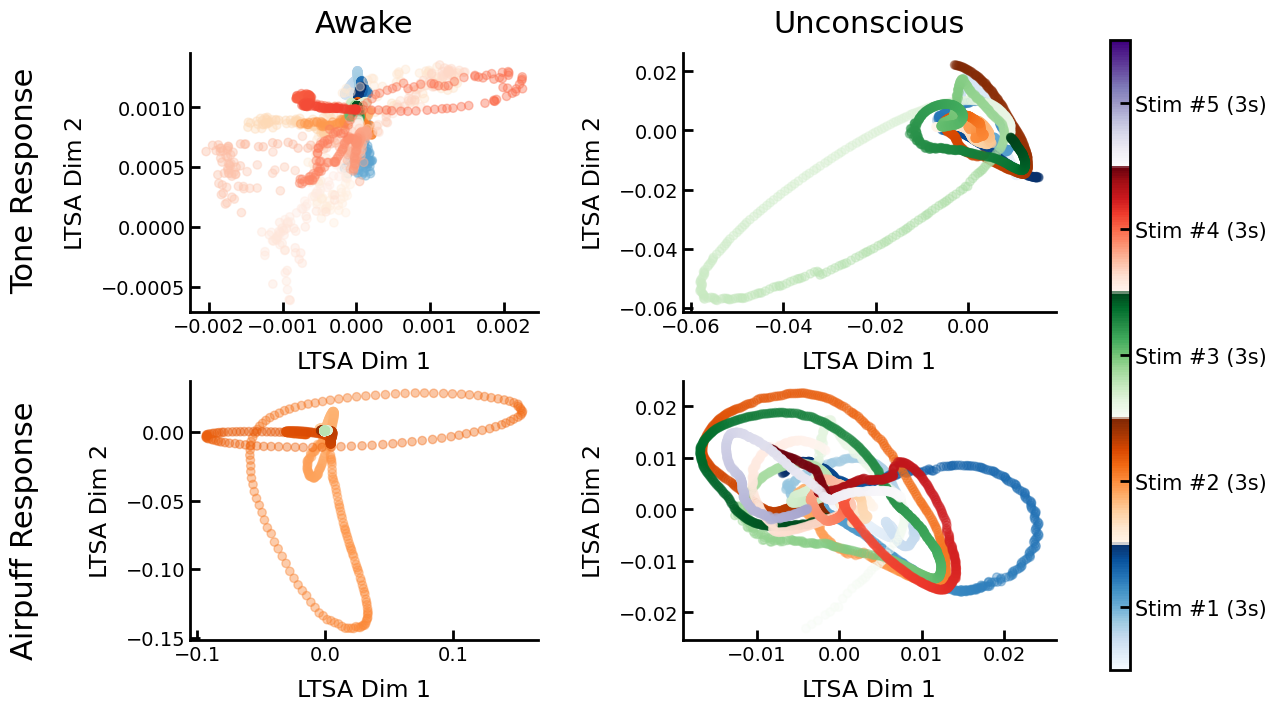

In [30]:
# stim_length = 1000
stim_length = 3000
ysuplabel_fontsize = 22
xlabel_fontsize = 17
ylabel_fontsize = 17
title_fontsize = 22
tick_fontsize = 14

embedded_signals = {}
embedded_signals[embed_func] = all_embedded_signals[t][embed_func]

input_vec = np.zeros(len(color_list))
alpha = 0.4

fig = plt.figure(layout='constrained', figsize=(10, 7))
subfigs = fig.subfigures(1, 2, wspace=0.07, hspace=0.07)

for plot_ind, t in enumerate(all_embedded_signals.keys()):
    
#     axs = subfigs[plot_ind].subplots(4, 1)
    axs = subfigs[plot_ind].subplots(2, 1)
    
    embedded_signals = {}
    embedded_signals[embed_func] = all_embedded_signals[t][embed_func]
    
#     input_vec = np.zeros(len(color_list))

#     for t_tone in tone_on[np.logical_and(tone_on >= t, tone_on <= t + window)]:
#         start = int((t_tone - t)/dt)
#         end = np.min([int((t_tone - t)/dt) + 1000, len(color_list)])
#         input_vec[start:end] += 1

#     for t_puff in puff_on[np.logical_and(puff_on >= t, puff_on <= t + window)]:
#         start = int((t_puff - t)/dt)
#         end = np.min([int((t_puff - t)/dt) + 1000, len(color_list)])
#         input_vec[start:end] += 3

#     #     alpha[input_vec > 0] = 1
#     #     alpha = alpha[np.arange(0, len(color_list), subsample)][-embedded_signals[embed_func].shape[0]:]

#     color_list4 = [(1/256, 1/256, 1/256, 1.0)]*len(color_list)
#     prev_val = None
#     power = 0
#     for i, input_val in enumerate(input_vec):

#         if prev_val == input_val:
#             power += 1
#         else:
#             power = 0
#         if input_val == 1:
#             B = np.linspace(0.5717531718569781, 1, 1000)
#             color_list4[i] = (0.5056516724336794, 0.7190311418685121, B[power], 1.0)
#         elif input_val == 3:
#             G = np.linspace(0.6173779315647828, 1, 1000)
#             color_list4[i] = (0.9831603229527105, G[power], 0.35040369088811996, 1.0)
#         elif input_val == 4:
#             R = np.linspace(0.8417531718569781, 1, 1000)
#             color_list4[i] = (R[power], 0.9690119184928874, 0.7020376778162245, 1.0)
#         if i > 0:
#             prev_val = input_vec[i - 1]

#     # plt.figure(figsize=(8, 5))
#     axs[0].scatter(embedded_signals[embed_func][:, 0], embedded_signals[embed_func][:, 1], color=np.array(color_list4)[np.arange(0, len(color_list), subsample)][-embedded_signals[embed_func].shape[0]:], alpha=alpha)
#     axs[1].remove()
#     axs[1]=subfigs[plot_ind].add_subplot(4, 1, 2, projection='3d')
#     axs[1].scatter(embedded_signals[embed_func][:, 0], embedded_signals[embed_func][:, 1], embedded_signals[embed_func][:, 2], color=np.array(color_list4)[np.arange(0, len(color_list), subsample)][-embedded_signals[embed_func].shape[0]:], alpha=alpha)
    
    for tone_num, t_tone in enumerate(tone_on[np.logical_and(tone_on >= t, tone_on <= t + window)]):

        tone_colors = np.zeros((stim_length, 4))
        cmap = plt.cm.get_cmap(cmap_names[tone_num])
        norm = Normalize(0, stim_length)
        for i in range(stim_length):
            tone_colors[i] = cmap(norm(i))
        tone_colors = tone_colors[np.arange(0, stim_length, subsample)]

        start = int((t_tone - t)/dt)
        end = np.min([int((t_tone - t)/dt) + stim_length, len(color_list)])
    #     input_vec[start:end] += 1
        subsampled_inds = np.arange(int(window/dt))[np.arange(0, int(window/dt), subsample)]
        plot_inds = np.where(np.logical_and(subsampled_inds >= start, subsampled_inds < end))[0]
        plot_inds -= int((delay_p - 1)*delay_tau/subsample)
        

#         dist = compute_start_end_distance(embedded_signals[embed_func][plot_inds])
#         print(f"t = {t}, tone {tone_num} = {dist}")
        
        axs[0].scatter(embedded_signals[embed_func][plot_inds, 0], embedded_signals[embed_func][plot_inds, 1], c=tone_colors[:len(plot_inds)], alpha=alpha)

#         axs[0].scatter([], [], color=cmap(norm(500)), alpha=alpha, label=f'Tone #{tone_num}')

#         axs[0].legend()

    for puff_num, t_puff in enumerate(puff_on[np.logical_and(puff_on >= t, puff_on <= t + window)]):

        puff_colors = np.zeros((stim_length, 4))
        cmap = plt.cm.get_cmap(cmap_names[puff_num])
        norm = Normalize(0, stim_length)
        for i in range(stim_length):
            puff_colors[i] = cmap(norm(i))
        puff_colors = puff_colors[np.arange(0, stim_length, subsample)]

        start = int((t_puff - t)/dt)
        end = np.min([int((t_puff - t)/dt) + stim_length, int(window/dt)])
    #     input_vec[start:end] += 1
        subsampled_inds = np.arange(int(window/dt))[np.arange(0, int(window/dt), subsample)]
        plot_inds = np.where(np.logical_and(subsampled_inds >= start, subsampled_inds < end))[0]
        plot_inds -= int((delay_p - 1)*delay_tau/subsample)
        
#         dist = compute_start_end_distance(embedded_signals[embed_func][plot_inds])
#         print(f"t = {t}, puff {puff_num} = {dist}")

        axs[1].scatter(embedded_signals[embed_func][plot_inds, 0], embedded_signals[embed_func][plot_inds, 1], c=puff_colors[:len(plot_inds)], alpha=alpha)

#         axs[1].scatter([], [], color=cmap(norm(500)), alpha=alpha, label=f'Puff #{puff_num}')

#         axs[1].legend()
    for ax in axs:
        ax.spines[['right', 'top']].set_visible(False)
        ax.xaxis.set_ticks_position('bottom')
        ax.tick_params(axis='y', which='both', left=True, right=False)
        ax.set_xlabel('LTSA Dim 1', fontsize=xlabel_fontsize)
        ax.set_ylabel('LTSA Dim 2', fontsize=ylabel_fontsize)
        ax.tick_params(labelsize=tick_fontsize)
    
    axs[0].set_title(['Awake', 'Unconscious'][plot_ind], fontsize=title_fontsize)
    if plot_ind == 0:
        fig.text(-0.05, 0.75, 'Tone Response', va='center', rotation='vertical', fontsize=ysuplabel_fontsize)
        fig.text(-0.05, 0.25, 'Airpuff Response', va='center', rotation='vertical', fontsize=ysuplabel_fontsize)
#         axs[0].set_ylabel('')
#         axs[0].set_ylabel('Tone Response')
#         axs[1].set_ylabel('Airpuff Response')

stack = None
for ind in range(len(cmap_names)):
    cmap = plt.cm.get_cmap(cmap_names[ind])
    if stack is None:
        stack = cmap((np.linspace(0, 1, 128)))
    else:
        stack = np.vstack([stack, cmap(np.linspace(0, 1, 128))])
# stack = np.vstack((plt.cm.get_cmap(cmap_names[0]), plt.cm.get_cmap(cmap_names[1])(np.linspace(0, 1, 128))))
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', stack)
# fig.legend(bbox_to_anchor=(0.5, -0.1), loc='center', ncol=5)

sm = plt.cm.ScalarMappable(cmap=mymap)
# fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([1.05, 0.05, 0.02, 0.9])
cbar = fig.colorbar(sm, ticks=np.arange(0.1, 1.01, 0.2), cax=cbar_ax)
cbar.ax.set_yticklabels([f"Stim #{i + 1} ({int(stim_length*dt)}s)" for i in range(5)], fontsize=15)

    # cbar = fig.colorbar(sm, cax=cbar_ax, ticks=np.arange(0, 1000, 100), label='Time Relative to Tone (ms)')
    # # cbar.ax.set_yticklabels(np.arange(start_ind, end_ind + 1, cbar_step), fontsize=12)
    # cbar.set_label(label=f'Time Relative to Tone Onset (s)', fontsize=14)

    # for t_puff in puff_on[np.logical_and(puff_on >= t, puff_on <= t + window)]:
    #     start = int((t_puff - t)/dt)
    #     end = np.min([int((t_puff - t)/dt) + 1000, len(color_list)])
    #     input_vec[start:end] += 3
    

    
plt.show()

In [120]:
def compute_start_end_distance(x, num_pts=50):
    x_normed = (x - x.mean())/x.std()
    return scipy.spatial.distance.cdist(x_normed[:num_pts], x_normed[-num_pts:]).mean()

In [92]:
# # stim_length = 1000
# stim_length = 3000
# ysuplabel_fontsize = 22
# xlabel_fontsize = 17
# ylabel_fontsize = 17
# title_fontsize = 22
# tick_fontsize = 14

# embedded_signals = {}
# embedded_signals[embed_func] = all_embedded_signals[t][embed_func]

# input_vec = np.zeros(len(color_list))
# alpha = 0.4

# fig = plt.figure(layout='constrained', figsize=(10, 7))
# subfigs = fig.subfigures(1, 2, wspace=0.07, hspace=0.07)

# for plot_ind, t in enumerate(all_embedded_signals.keys()):
    
# #     axs = subfigs[plot_ind].subplots(4, 1)
#     axs = subfigs[plot_ind].subplots(2, 1)
    
#     embedded_signals = {}
#     embedded_signals[embed_func] = all_embedded_signals[t][embed_func]
    
# #     input_vec = np.zeros(len(color_list))

# #     for t_tone in tone_on[np.logical_and(tone_on >= t, tone_on <= t + window)]:
# #         start = int((t_tone - t)/dt)
# #         end = np.min([int((t_tone - t)/dt) + 1000, len(color_list)])
# #         input_vec[start:end] += 1

# #     for t_puff in puff_on[np.logical_and(puff_on >= t, puff_on <= t + window)]:
# #         start = int((t_puff - t)/dt)
# #         end = np.min([int((t_puff - t)/dt) + 1000, len(color_list)])
# #         input_vec[start:end] += 3

# #     #     alpha[input_vec > 0] = 1
# #     #     alpha = alpha[np.arange(0, len(color_list), subsample)][-embedded_signals[embed_func].shape[0]:]

# #     color_list4 = [(1/256, 1/256, 1/256, 1.0)]*len(color_list)
# #     prev_val = None
# #     power = 0
# #     for i, input_val in enumerate(input_vec):

# #         if prev_val == input_val:
# #             power += 1
# #         else:
# #             power = 0
# #         if input_val == 1:
# #             B = np.linspace(0.5717531718569781, 1, 1000)
# #             color_list4[i] = (0.5056516724336794, 0.7190311418685121, B[power], 1.0)
# #         elif input_val == 3:
# #             G = np.linspace(0.6173779315647828, 1, 1000)
# #             color_list4[i] = (0.9831603229527105, G[power], 0.35040369088811996, 1.0)
# #         elif input_val == 4:
# #             R = np.linspace(0.8417531718569781, 1, 1000)
# #             color_list4[i] = (R[power], 0.9690119184928874, 0.7020376778162245, 1.0)
# #         if i > 0:
# #             prev_val = input_vec[i - 1]

# #     # plt.figure(figsize=(8, 5))
# #     axs[0].scatter(embedded_signals[embed_func][:, 0], embedded_signals[embed_func][:, 1], color=np.array(color_list4)[np.arange(0, len(color_list), subsample)][-embedded_signals[embed_func].shape[0]:], alpha=alpha)
# #     axs[1].remove()
# #     axs[1]=subfigs[plot_ind].add_subplot(4, 1, 2, projection='3d')
# #     axs[1].scatter(embedded_signals[embed_func][:, 0], embedded_signals[embed_func][:, 1], embedded_signals[embed_func][:, 2], color=np.array(color_list4)[np.arange(0, len(color_list), subsample)][-embedded_signals[embed_func].shape[0]:], alpha=alpha)
    
#     for tone_num, t_tone in enumerate(tone_on[np.logical_and(tone_on >= t, tone_on <= t + window)]):

#         tone_colors = np.zeros((stim_length, 4))
#         cmap = plt.cm.get_cmap(cmap_names[tone_num])
#         norm = Normalize(0, stim_length)
#         for i in range(stim_length):
#             tone_colors[i] = cmap(norm(i))
#         tone_colors = tone_colors[np.arange(0, stim_length, subsample)]

#         start = int((t_tone - t)/dt)
#         end = np.min([int((t_tone - t)/dt) + stim_length, len(color_list)])
#     #     input_vec[start:end] += 1
#         subsampled_inds = np.arange(int(window/dt))[np.arange(0, int(window/dt), subsample)]
#         plot_inds = np.where(np.logical_and(subsampled_inds >= start, subsampled_inds < end))[0]
#         plot_inds -= int((delay_p - 1)*delay_tau/subsample)
        
#         if tone_num not in [0, 3, 4]:
#             axs[0].scatter(embedded_signals[embed_func][plot_inds, 0], embedded_signals[embed_func][plot_inds, 1], c=tone_colors[:len(plot_inds)], alpha=alpha)

# #         axs[0].scatter([], [], color=cmap(norm(500)), alpha=alpha, label=f'Tone #{tone_num}')

# #         axs[0].legend()

#     for puff_num, t_puff in enumerate(puff_on[np.logical_and(puff_on >= t, puff_on <= t + window)]):

#         puff_colors = np.zeros((stim_length, 4))
#         cmap = plt.cm.get_cmap(cmap_names[puff_num])
#         norm = Normalize(0, stim_length)
#         for i in range(stim_length):
#             puff_colors[i] = cmap(norm(i))
#         puff_colors = puff_colors[np.arange(0, stim_length, subsample)]

#         start = int((t_puff - t)/dt)
#         end = np.min([int((t_puff - t)/dt) + stim_length, int(window/dt)])
#     #     input_vec[start:end] += 1
#         subsampled_inds = np.arange(int(window/dt))[np.arange(0, int(window/dt), subsample)]
#         plot_inds = np.where(np.logical_and(subsampled_inds >= start, subsampled_inds < end))[0]
#         plot_inds -= int((delay_p - 1)*delay_tau/subsample)
#         if puff_num not in [0, 3, 4]:
#             axs[1].scatter(embedded_signals[embed_func][plot_inds, 0], embedded_signals[embed_func][plot_inds, 1], c=puff_colors[:len(plot_inds)], alpha=alpha)

# #         axs[1].scatter([], [], color=cmap(norm(500)), alpha=alpha, label=f'Puff #{puff_num}')

# #         axs[1].legend()
#     for ax in axs:
#         ax.spines[['right', 'top']].set_visible(False)
#         ax.xaxis.set_ticks_position('bottom')
#         ax.tick_params(axis='y', which='both', left=True, right=False)
#         ax.set_xlabel('LTSA Dim 1', fontsize=xlabel_fontsize)
#         ax.set_ylabel('LTSA Dim 2', fontsize=ylabel_fontsize)
#         ax.tick_params(labelsize=tick_fontsize)
    
#     axs[0].set_title(['Awake', 'Unconscious'][plot_ind], fontsize=title_fontsize)
#     if plot_ind == 0:
#         fig.text(-0.05, 0.75, 'Tone Response', va='center', rotation='vertical', fontsize=ysuplabel_fontsize)
#         fig.text(-0.05, 0.25, 'Airpuff Response', va='center', rotation='vertical', fontsize=ysuplabel_fontsize)
# #         axs[0].set_ylabel('')
# #         axs[0].set_ylabel('Tone Response')
# #         axs[1].set_ylabel('Airpuff Response')

# stack = None
# for ind in range(len(cmap_names)):
#     cmap = plt.cm.get_cmap(cmap_names[ind])
#     if stack is None:
#         stack = cmap((np.linspace(0, 1, 128)))
#     else:
#         stack = np.vstack([stack, cmap(np.linspace(0, 1, 128))])
# # stack = np.vstack((plt.cm.get_cmap(cmap_names[0]), plt.cm.get_cmap(cmap_names[1])(np.linspace(0, 1, 128))))
# mymap = colors.LinearSegmentedColormap.from_list('my_colormap', stack)
# # fig.legend(bbox_to_anchor=(0.5, -0.1), loc='center', ncol=5)

# sm = plt.cm.ScalarMappable(cmap=mymap)
# # fig.subplots_adjust(right=0.85)
# cbar_ax = fig.add_axes([1.05, 0.05, 0.02, 0.9])
# cbar = fig.colorbar(sm, ticks=np.arange(0.1, 1.01, 0.2), cax=cbar_ax)
# cbar.ax.set_yticklabels([f"Stim #{i + 1} (1 s)" for i in range(5)], fontsize=15)

#     # cbar = fig.colorbar(sm, cax=cbar_ax, ticks=np.arange(0, 1000, 100), label='Time Relative to Tone (ms)')
#     # # cbar.ax.set_yticklabels(np.arange(start_ind, end_ind + 1, cbar_step), fontsize=12)
#     # cbar.set_label(label=f'Time Relative to Tone Onset (s)', fontsize=14)

#     # for t_puff in puff_on[np.logical_and(puff_on >= t, puff_on <= t + window)]:
#     #     start = int((t_puff - t)/dt)
#     #     end = np.min([int((t_puff - t)/dt) + 1000, len(color_list)])
#     #     input_vec[start:end] += 3
    

    
# plt.show()

# Extra

In [186]:
embedded_signals = all_embedded_signals[list(all_embedded_signals.keys())[0]]

In [187]:
t_puff = puff_on[np.logical_and(puff_on >= t, puff_on <= t + window)][0]

In [193]:
start = int((t_puff - t)/dt)
end = np.min([int((t_puff - t)/dt) + 2000, int(window/dt)])
#     input_vec[start:end] += 1
subsampled_inds = np.arange(int(window/dt))[np.arange(0, int(window/dt), subsample)]
plot_inds = np.where(np.logical_and(subsampled_inds >= start, subsampled_inds < end))[0]
plot_inds -= int((delay_p - 1)*delay_tau/subsample)

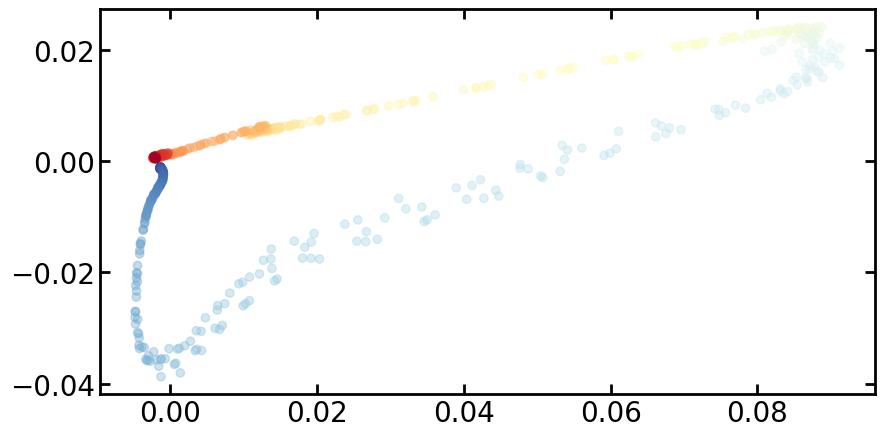

In [194]:
plt.scatter(embedded_signals[embed_func][plot_inds, 0], embedded_signals[embed_func][plot_inds, 1], c=plt.cm.get_cmap('RdYlBu_r')(np.linspace(0, 1, len(plot_inds))), alpha=alpha)